<a href="https://colab.research.google.com/github/claudia-viaro/optimal_switching/blob/main/optimal_stopping_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Formulation
Let $(\Omega, \mathcal{F}, P)$ be a fixed probability space on which an adapted stochastic process is defined $X=(X_t)_{0 \leq t \leq T}$ whose natural filtration is $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. Let $\mathbf{F}=(\mathcal{F}_0)_{0 \leq t \leq t}$ be the complete filtration of $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. with $P$-null sets of $\mathcal{F}$.

The stochastic process $X$ is $\mathbb{R}^d$-valued and represents the market price of $d$ financial assets (Bermudan call options) that influence the production of power. Assume $(X^i)_{i=1}^d$ follows a geometric Brownian motion satisfying the SDE:
\begin{equation}
dX_t = b_{I_t}X_tdt + \sigma_{I_t}X_tdW_t
\end{equation}
where $W$ is a standard Brownian otion on a filtered probability space $(\Omega, \mathcal{F}, \mathbf{F}=(\mathcal{F}_t)_{t \geq 0} P)$ and $I_t$ is the indicator variable of the regimes valued in $\mathbf{I}_d = \{1, \ldots, d \}$. $b_i \in \mathbf{R}$ and $\sigma_i >0$ are the drift and volatility of the system $X$ once in regime $I_t=i$ at time $t$.

We will consider a discrete approximization (Euler schema) with respect to. For $i = 1, \ldots, d$ we simulate $p$ paths
\begin{equation}
X^p_{n,i} = \exp \Big\{ \sum_{k=0}^n \big( (b-\sigma^2_i /2)_{\mathbf{I}}\Delta t + \sigma_{i, \mathbf{I}} \sqrt{\Delta t} \cdot Z_{k, i}^p \big)     \Big\}
\end{equation}
where $\Delta t = T/N$ and $Z_{k, i}^{p} \sim \mathcal{N} (0,1)$.



In [67]:
import numpy as np
import torch
import torch.nn as nn
np.random.seed(234198)
import itertools
import random
import time
import scipy.stats
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as tdata

In [78]:
''' 
underlying process - Geometric brownian motion
'''

class GBM:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike, dividend=0):
    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.dt = self.maturity / self.periods
    self.df = math.exp(-drift * self.dt)
    self.strike = strike

  def simulate_process(self):
    """Returns array of dimension (paths x periods x assets) """
    paths = self.paths
    path = np.array([self.simulate_one_path() for i in range(paths)]) 
    return path.reshape(path.shape[2], path.shape[0], path.shape[1])

  def drift_fct(self,x):
    return  (self.drift-self.delta-0.5*self.sigma**2)* x

  def diffusion_fct(self,x):
    return self.sigma * x


  def simulate_one_path(self):
    ''' if a single path '''
    path = np.empty((self.assets, self.periods+1))
    path[:, 0] = self.spot
    for k in range(1, self.periods+1):
      random_numbers = np.random.normal(0, 1, self.assets)
      dW =(random_numbers*np.sqrt(self.dt))
      previous_spots = path[:, k - 1]
      diffusion = (self.diffusion_fct(previous_spots))
      path[:, k] = (
          previous_spots
          + self.drift_fct(previous_spots)* self.dt
          + diffusion*dW) 
    return path   


class stock:
    def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike = 100,dividend=0):
        self.maturity = maturity
        self.strike = strike
        self.assets = assets
        self.sigma=sigma *np.ones(self.assets)
        self.delta=delta
        self.spot = spot*np.ones(self.assets)
        self.drift = drift - dividend
        self.paths = paths
        self.periods = periods
        self.dt = self.maturity / self.periods
    
    def GBM(self):
        
        dt = self.maturity / self.periods
        So_vec=self.spot*np.ones((1,S.paths, S.assets))
        
        Z=np.random.standard_normal((self.periods,self.paths, self.assets))
        s=self.spot*np.exp(np.cumsum((self.drift-0.5*self.sigma**2)*self.dt+self.sigma*np.sqrt(self.dt)*Z, axis=0))
        
        s=np.append(So_vec, s, axis=0)
        return s    

As introduced, the stochastic system can operate in $m$ modes or regimes from the finite set $\mathbb{I}=\{1, \ldots , m \}$. In this case we consider $m=2$ with $\mathbb{I}=\{\text{on}, \text{off} \}$. 

The regimes can be switched at a sequence of stopping times over a finite horizon $[0, \ldots , T]$.

There is a payoff rate per unit of time when the system is in mode $i \in \mathbb{I}$ at time $t$ as a mapping $\Psi_i(t, X_t): \Omega \times [0, T] \rightarrow \mathbb{R}$. The payoff function for the call option used is of the form $( \max_{i \in \{ 1, \ldots , d \}} X_t^i - K) ^{+}$, where $K$ is the strike price at any point in the time grid $0 = t_0 < t_1 < \ldots < t_N = T$. the system also outputs a final reward for being in mode $i \in \mathbb{I}$ at time $T$ given by $\Gamma_i$.

There is a cost for switching from regime $i$ to $j$ given by the function $\gamma_{i, j} : \Omega \times [0, T] \rightarrow \mathbb{R} $ to cover for the extra costs due to the change of the regime.

A strategy $\alpha$ for the power plant will be a combination of two sequences:
- non decreasing sequence of $\mathbb{F}$-stopping times $(\tau_n)_{n \geq 1}$, $n \in \mathbb{N} \backslash \{0\}$, where at $\tau_n$ the production is swithced from the current mode $i$ to $j$. we also assume: $\tau_0=t$ and $\tau_n \leq \tau_{n+1}$.
- a sequence of indicators $(\iota)_{n \geq 1}$, $n \in \mathbb{N} \backslash \{0\}$, $\mathcal{F}_{\tau_n}$- measurable valued in $\mathbb{I}_m$. At time $t=\tau_n$ the system is switched from the current regime $\iota_{n-1}$ to $\iota_{n}$, with $\iota_{0}=i$.

We denote by $\mathcal{A}_{t, i}$ the set of admissible strategies to switch at time $\tau_n$, $n \geq 1$, from the current regime $\iota_{n-1}$ to $\iota_{n}$. 


For any initial condition $(x, i) \in [0, T] \times \mathbb{I}_m$, and any control $\alpha=(\tau_n, \iota_n)_{n \leq 0} \in \mathcal{A}_{t, i}$. the total expected payoff up to $T$ for such strategy can be expressed as: 
\begin{equation}
J_i(x, \alpha) = \mathbb{E} \Big[ \sum_{s=t}^{T-1} \Psi(X_t^{x, i}, I_t^i) + \Gamma - \sum_{n \leq 1}\gamma_{\iota_{n-1}, \iota_n} \mathbf{1}_{ \{ \tau_n < T \} }  | \mathcal{F}_n   \Big]
\end{equation}

The objective is to maximize this expected total profit for all strategies $\alpha$. For this purpose, we set the value function:
\begin{equation}
V_i(x)=\sup_{\alpha \in \mathcal{A}} J_i(x, \alpha) \;\;\;\;\;\;\;\;\; \forall \alpha \in \mathcal{A}_{t, i} \,\, \mathbb{P}\; a.s. 
\end{equation}

Following Becker, Cheridito and Jentzen, we reformulate stopping time problem into a sequence of $0-1$ stopping decisions. To optimally stop the Markov process $X$ we make stopping decisions according to $f_n(X_n)$ for measurable functions $f_n: \mathbb{R}^d → \{0, 1 \}, n \in \mathbb{N}$. By construction $f_N \equiv 1$ as at $n=N$ there is a terminal stopping decision where $\tau_N \equiv N$. 

Given $n \in \{0, 1, \ldots, N-1 \}$ and the final stopping decision, let $\tau_{n+1}$ be a stopping time in $\mathcal{T}_{n+1}$ of the form:
\begin{equation}
\tau_{n+1} = \sum_{m=n+1}^N m f_m(X_m) \prod _{j=n+1}^{m-1} (1-f_j(X_j))
\end{equation}


To approach the problem, we iteratively approximate the optimal stopping decisions $f_n: \mathbb{R}^d \rightarrow \{0, 1 \}, n = \{ 1, 2, \ldots, N-1 \}$, by a neural network $f^{\theta}: \mathbb{R}^d \rightarrow \{0, 1 \}$ with parameter $\theta \in \mathbb{R}^q$. We choose $\theta_N \in \mathbb{R}^q$ such that $f^{\theta}_N \equiv 1$ and determine $\theta_n \in \mathbb{R}^q$ for $n \leq N-1$ by recursion of the form:

\begin{equation}
\tau_{n+1} = \sum_{m=n+1}^N m f^{\theta_m}(X_m) \prod _{j=n+1}^{m-1} (1-f^{\theta_j}(X_j))
\end{equation}

Since $f^{\theta}$ takes values in $\{ 0,1 \}$, hence not appropriate for a gradient-descent optimization method, the neural network includes a layer performing a logostic transformation such that we have the resulting output function $F^{\theta}: \mathbb{R}^d \rightarrow (0,1)$.

The Neural network includes $(d+40)$ hidden units and comprises a combination of linear and rectified linear activation functions. 

In [69]:
class Ftheta_NN(nn.Module):
  def __init__(self, assets):
    super(Ftheta_NN, self).__init__()
    H = assets + 40
    self.bn0 = nn.BatchNorm1d(num_features=assets)
    self.layer1 = nn.Linear(assets, H)
    self.leakyReLU = nn.LeakyReLU(0.5)
    self.Softplus = nn.Softplus()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(num_features=H)
    self.layer2 = nn.Linear(H, H)
    self.bn2 = nn.BatchNorm1d(num_features=H)
    self.layer3 = nn.Linear(H, 1)
    self.bn3 = nn.BatchNorm1d(num_features=1)

  def forward(self, x):
    x = self.bn0(x)
    x = self.layer1(x)
    x = self.relu(x)
    x = self.bn2(x)
    x = self.layer3(x)
    x = self.sigmoid(x)
    return x



# set initial weights of a linear layer of the NN with uniform values and bias=0.01 (or choose zero initial weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.manual_seed(42)
    # torch.nn.init.zeros_(m.weight)
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)
    
 

In [70]:
'''
PAYOFF
'''

# Payoff
class Payoff:
  def __init__(self, model):
    self.strike = model.strike
    self.model = model

  def MaxCall(self, n, m, X):
    max1=torch.max(X[int(n),m,:].float()-self.strike)
    return np.exp(-self.model.drift*(self.model.maturity/self.model.periods)*n)*torch.max(max1,torch.tensor([0.0]))

  def MaxPut(self, n, m, X):
    max1=self.strike - torch.max(X[int(n),m,:].float())
    return np.exp(-self.model.drift*(self.model.maturity/self.model.periods)*n)*torch.max(max1,torch.tensor([0.0]))  


  def GeometricPut(self, n, m, X):
    dim = len(X[1])  
    payoff = self.strike - np.prod(X, axis=1) ** (1/dim)
    return payoff.clip(0, None)
 
        


In [71]:
'''
OPTIMIZATION AND LOSS FUNCTION
'''

def Optim(n,X,S, tau_n_plus_1): # Y is Y_train, n is date, tau_n_plus_1 is tau_mat_test[date+1]
    epochs=50
    network=Ftheta_NN(S.assets)
    optimizer = torch.optim.Adam(network.parameters(), lr = 0.0001)

    for epoch in range(epochs):
        F = network.forward(X[n])   #torch.from_numpy(X[n]).float())  # probabilities
        reward = loss(F,S,X,n,tau_n_plus_1) 
        reward.backward()
        optimizer.step()
    
    return F,network

def loss(y_pred,S, X, n, tau): # input tau is tau_mat_test[date+1]
    payoff = Payoff(S)
    r_n=torch.zeros((S.paths))
    for m in range(0,S.paths):

        r_n[m]=-(payoff.MaxPut(n,m,X)*y_pred[m] + payoff.MaxPut(tau[m],m,X)*(1-y_pred[m]))
    
    return(r_n.mean())


In [72]:
class Training:
  def __init__(self, model, payoff, nb_epochs=50):

    self.model = model # argument is S    
    self.payoff = payoff(self.model)

  def price(self):
    model = self.model
    stock_paths = torch.from_numpy(self.model.simulate_process()).float()
    
    # create empty objects to store values
    tau_dates=np.zeros((model.periods+1,model.paths))
    tau_dates[model.periods,:]=model.periods
    F_theta_train=np.zeros((model.periods+1,model.paths))
    F_theta_train[model.periods,:]=1
    mods=[None]*model.periods
        
    # recursive calc. before maturity
    for date in range(model.periods - 1, -1, -1):
      probs, mod_temp=Optim(date, stock_paths, model, torch.from_numpy((tau_dates[date+1]-1)).float())
      np_probs=probs.detach().numpy().reshape(model.paths)
      mods[date]=mod_temp
      print(date, ":", np.min(np_probs)," , ", np.max(np_probs),  " , ", len([1 for l in np_probs if l > 0.5])) # print the min/max stopping probabilities and the count of stopping times for each date
      F_theta_train[date,:]=(np_probs > 0.5)*1.0
      tau_dates[date,:]=np.argmax(F_theta_train, axis=0) 

    return mods 

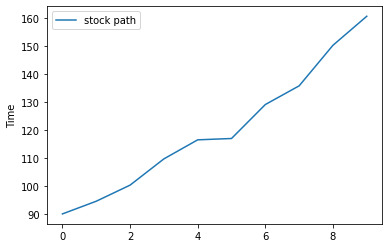

(10, 5000, 10)


In [79]:
# generate underlying stochastic process

hyperparam_test_stock_models = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':5000, 'periods': 9, 'maturity': 3., 'strike' : 100,'assets':10,  'spot':90,}
#S = GBM(**hyperparam_test_stock_models)
#X=S.simulate_process()


S=stock(**hyperparam_test_stock_models)
X=S.GBM()



def draw_stock_model(stockmodel):
    stock_paths = stockmodel

    # draw a path
    one_path = stock_paths[:, 0, 0]
    dates = np.array([i for i in range(len(one_path))])
    plt.plot(dates, one_path, label='stock path')
    plt.ylabel('Stock price')
    plt.ylabel('Time')
    plt.legend()
    return plt.show()   

draw_stock_model(X)   
print(X.shape) # (date, path, asset)


In [74]:
pricingtraining = Training(S, Payoff,  nb_epochs=50)
mods = pricingtraining.price()

8 : 0.17710392  ,  0.8207418  ,  3211
7 : 0.004856346  ,  0.981293  ,  2666
6 : 0.113336  ,  0.89031506  ,  2400
5 : 0.18957058  ,  0.9835541  ,  1868
4 : 0.19390869  ,  0.88882995  ,  2259
3 : 0.09406293  ,  0.95163435  ,  2329
2 : 0.2135076  ,  0.7421192  ,  2301
1 : 0.16155478  ,  0.8957554  ,  2666
0 : 0.03996482  ,  0.83406204  ,  3031


In [75]:
# Testing

class Testing:
  def __init__(self, model, payoff, mods, nb_epochs=50):   
    self.model = model # argument is S   
    self.payoff = payoff(self.model)
    self.mods = mods

  def price(self):
    model = self.model
    stock_paths = torch.from_numpy(self.model.simulate_process()).float()
    
    # create empty objects to store values
    tau_dates=np.zeros((model.periods+1,model.paths))
    tau_dates[model.periods,:]=model.periods
    F_theta_test=np.zeros((model.periods+1,model.paths))
    F_theta_test[model.periods,:]=1
    Y_test=np.zeros((self.model.periods+1, self.model.paths))
    Y_test_mean = np.zeros((self.model.periods+1))
    

    # at maturity N
    for path in range(0,self.model.paths):
      Y_test[self.model.periods, path]=self.payoff.MaxPut(self.model.periods, path, stock_paths)
        
    Y_test_mean[self.model.periods]=np.mean(Y_test[self.model.periods,:])
    print(self.model.periods, ":", F_theta_test[self.model.periods,:][0],  " , ", len([1 for l in F_theta_test[self.model.periods,:] if l > 0.5])) # print the min/max stopping probabilities and the count of stopping times for each date

    # recursive calc. before maturity
    for date in range(model.periods - 1, -1, -1):
       mod_curr=self.mods[date]
       probs=mod_curr(stock_paths[date])
       np_probs=probs.detach().numpy().reshape(self.model.paths)
       F_theta_test[date,:]=(np_probs > 0.5)*1.0
       tau_dates[date,:]=np.argmax(F_theta_test, axis=0) 
       print(date, ":", np.min(np_probs)," , ", np.max(np_probs),  " , ", len([1 for l in np_probs if l > 0.5])) # print the min/max stopping probabilities and the count of stopping times for each date

       for path in range(0,self.model.paths):
         Y_test[date, path]=np.exp((date-tau_dates[date, path])*(-self.model.drift*self.model.maturity/self.model.periods))*self.payoff.MaxPut(tau_dates[date, path], path,stock_paths) 

    Y_test_mean=np.mean(Y_test, axis=1)
    Y_test_std=np.std(Y_test, axis=1)
    Y_test_se=Y_test_std/(np.sqrt(self.model.paths))

    z=scipy.stats.norm.ppf(0.975)
    lower=Y_test_se - z*Y_test_se
    upper=Y_test_se + z*Y_test_se

    return Y_test_mean, upper, lower 



In [76]:
modelclass=GBM(**hyperparam_test_stock_models)
price_testing = Testing(modelclass, Payoff, mods, nb_epochs=50)
Y_test_mean, upper, lower = price_testing.price()

9 : 1.0  ,  5000
8 : 0.18173753  ,  0.8056721  ,  3254
7 : 0.0054105883  ,  0.97051203  ,  2612
6 : 0.12509997  ,  0.8985979  ,  2345
5 : 0.20487611  ,  0.9803831  ,  1897
4 : 0.17155345  ,  0.88921094  ,  2274
3 : 0.13186538  ,  0.95619196  ,  2335
2 : 0.18478186  ,  0.76460165  ,  2315
1 : 0.14524548  ,  0.8880913  ,  2687
0 : 0.02227343  ,  0.85705066  ,  3125


Text(0, 0.5, 'Value')

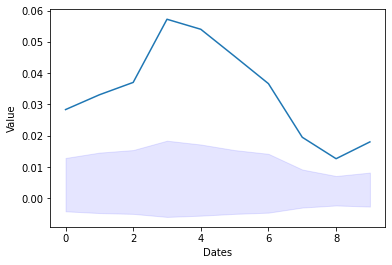

In [77]:
dates = np.array([i for i in range(len(Y_test_mean))])
fig, ax = plt.subplots()
ax.plot(dates,Y_test_mean)
ax.fill_between(dates, (lower), (upper), color='b', alpha=.1)
plt.xlabel("Dates")
plt.ylabel("Value")